In [1]:
import os
import sys
import yaml
import math
import pickle
import itertools
from copy import deepcopy

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

import src.utils.numpy_nest_utils as np_nest
from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
# %matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Inversitgating the inhomogenity of data that we have devised

In [2]:
with open('../../experiment_configs/inhomogenity_investigation/pvi_adult_inhomo.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
# with open('../../experiment_configs/batch_VI_comparison/PVI_baseline.yaml', 'r') as f:
#     PVI_config = yaml.load(f, Loader=yaml.FullLoader)
    
database_name = experiment_config['database']
if isinstance(database_name, list):
    database_name = database_name[0]
    
experiment_config = flatten_dict(experiment_config)
# PVI_config = flatten_dict(PVI_config)

def remove_singleton_dict_entries(d, protect=[], enforce=[]):
    remove_list = []
    for k, v in d.items():
        if isinstance(v, list):
            if len(v) == 1:
                remove_list.append(k)
            else:
                continue
        else:
            remove_list.append(k)
      
    for p in protect:
        if p in remove_list:
            remove_list.remove(p)
    
    for e in enforce:
        if e in d:
            remove_list.append(e)
    
    for k in remove_list: d.pop(k)
        
    return d

experiment_config = remove_singleton_dict_entries(experiment_config, protect=['dataset_dist.client_size_factor', 'dataset_dist.class_balance_factor', 'dataset.name'])

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
configs = [dict(item) for item in product]

In [3]:
results_access = SacredExperimentAccess(database_name=database_name)

In [4]:
pvi_configs = deepcopy(configs)
bvi_configs = deepcopy(configs)

for config in pvi_configs:
    config['experiment_tag'] = 'pvi'
    config['N_iterations'] = 100

for config in bvi_configs:
    config['experiment_tag'] = 'batch_vi'

pvi_grid_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_configs]
bvi_grid_experiments = [results_access.get_experiments(complete=True, config=config) for config in bvi_configs]

pvi_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in pvi_grid_experiments]
bvi_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in bvi_grid_experiments]

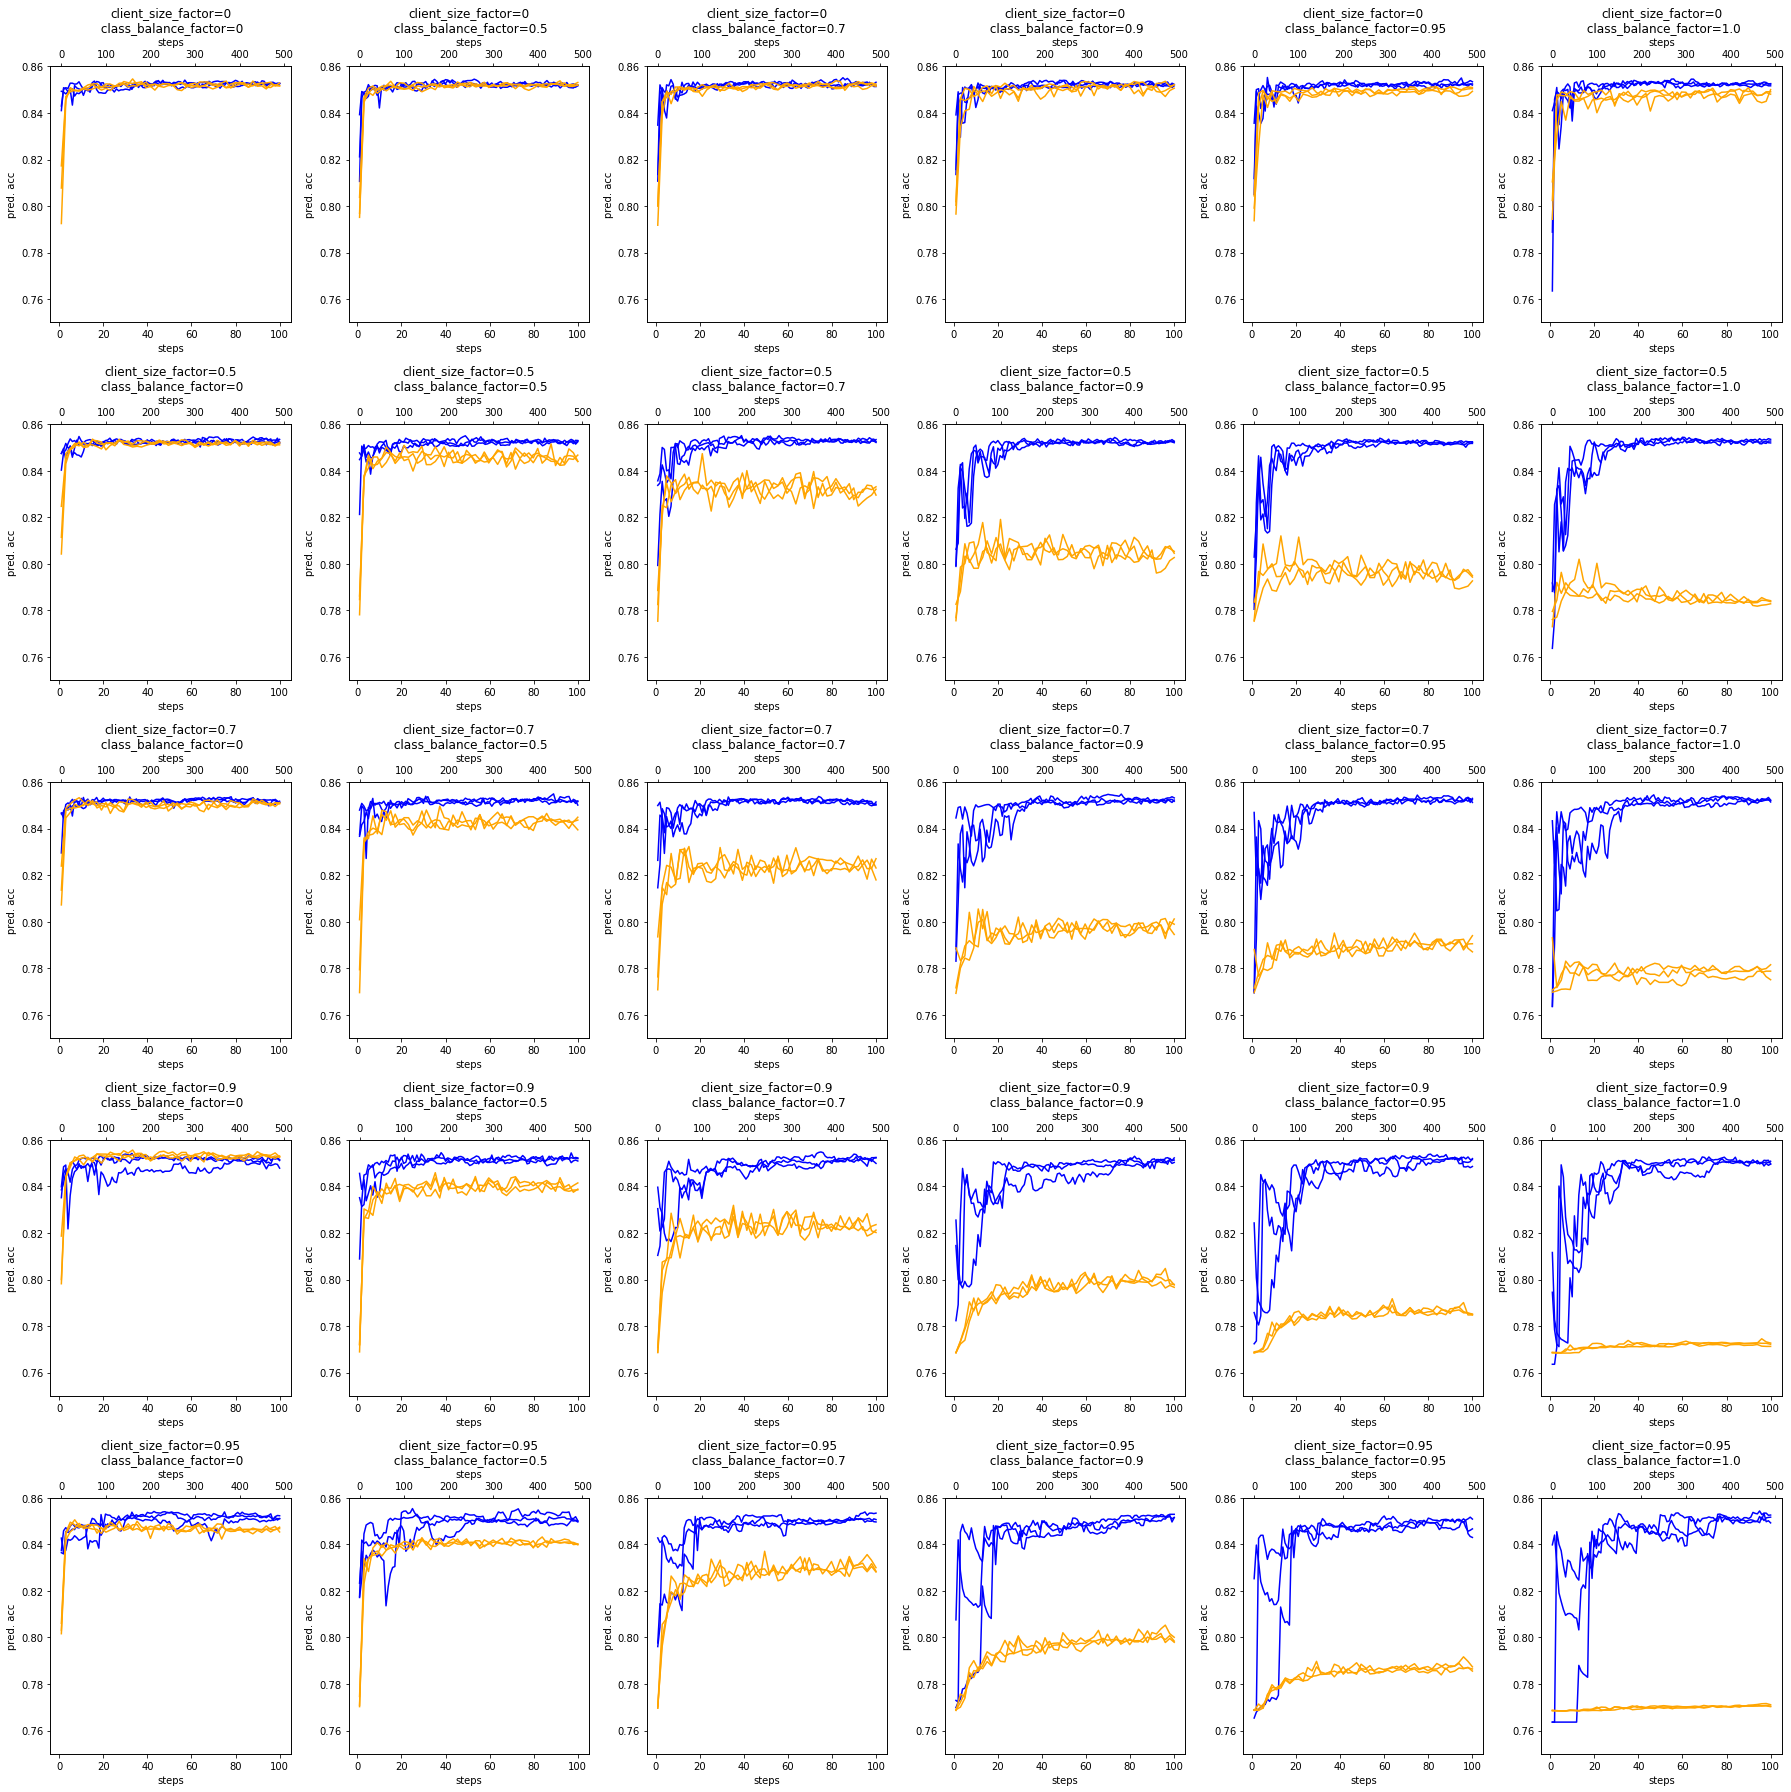

In [5]:
client_size_factors = sorted(experiment_config['dataset_dist.client_size_factor'])
class_balance_factors = sorted(experiment_config['dataset_dist.class_balance_factor'])

plt.figure(figsize=(25,25))
rows = len(client_size_factors)
cols = len(class_balance_factors)

for pvi_config, pvi_grid_experiment, pvi_grid_metric, bvi_config, bvi_grid_experiment, bvi_grid_metric in zip(pvi_configs, pvi_grid_experiments, pvi_grid_metrics, bvi_configs, bvi_grid_experiments, bvi_grid_metrics):
    client_size_factor = pvi_config['dataset_dist.client_size_factor']
    class_balance_factor = pvi_config['dataset_dist.class_balance_factor']
    
    client_size_factor_index = client_size_factors.index(client_size_factor)
    class_balance_factor_index = class_balance_factors.index(class_balance_factor)
    
    axes = plt.subplot(rows, cols, client_size_factor_index * cols + class_balance_factor_index + 1)
#     print(rho_index, inhom_index ,rho_index * cols + inhom_index + 1)
    
    if not len(pvi_grid_metric) == 0:
        pvi_values = []
        for metric in pvi_grid_metric:
            pvi_values.append(metric[0]['values'])
        pvi_values = np.array(pvi_values).T
        steps = np.atleast_2d(np.array(pvi_grid_metric[0][0]['steps'])).T
        
        axes.plot(steps, pvi_values, color='blue')
    
    axes2 = axes.twiny()
    
    if not len(bvi_grid_metric) == 0:
        bvi_values = []
        for metric in bvi_grid_metric:
            bvi_values.append(metric[0]['values'])
        bvi_values = np.array(bvi_values).T
        steps = np.atleast_2d(np.array(bvi_grid_metric[0][0]['steps'])).T
        
        axes2.plot(steps, bvi_values, color='orange')
        
    plt.title(f'client_size_factor={client_size_factor}\n class_balance_factor={class_balance_factor}')
    
#     axes.set_ylim([0.78, 0.86])
#     axes.set_xlim([0, 100])
    
    axes.set_xlabel('steps')
    axes2.set_xlabel('steps')
    axes.set_ylabel('pred. acc')
    axes.set_ylim([0.75, 0.86])
    
plt.tight_layout()

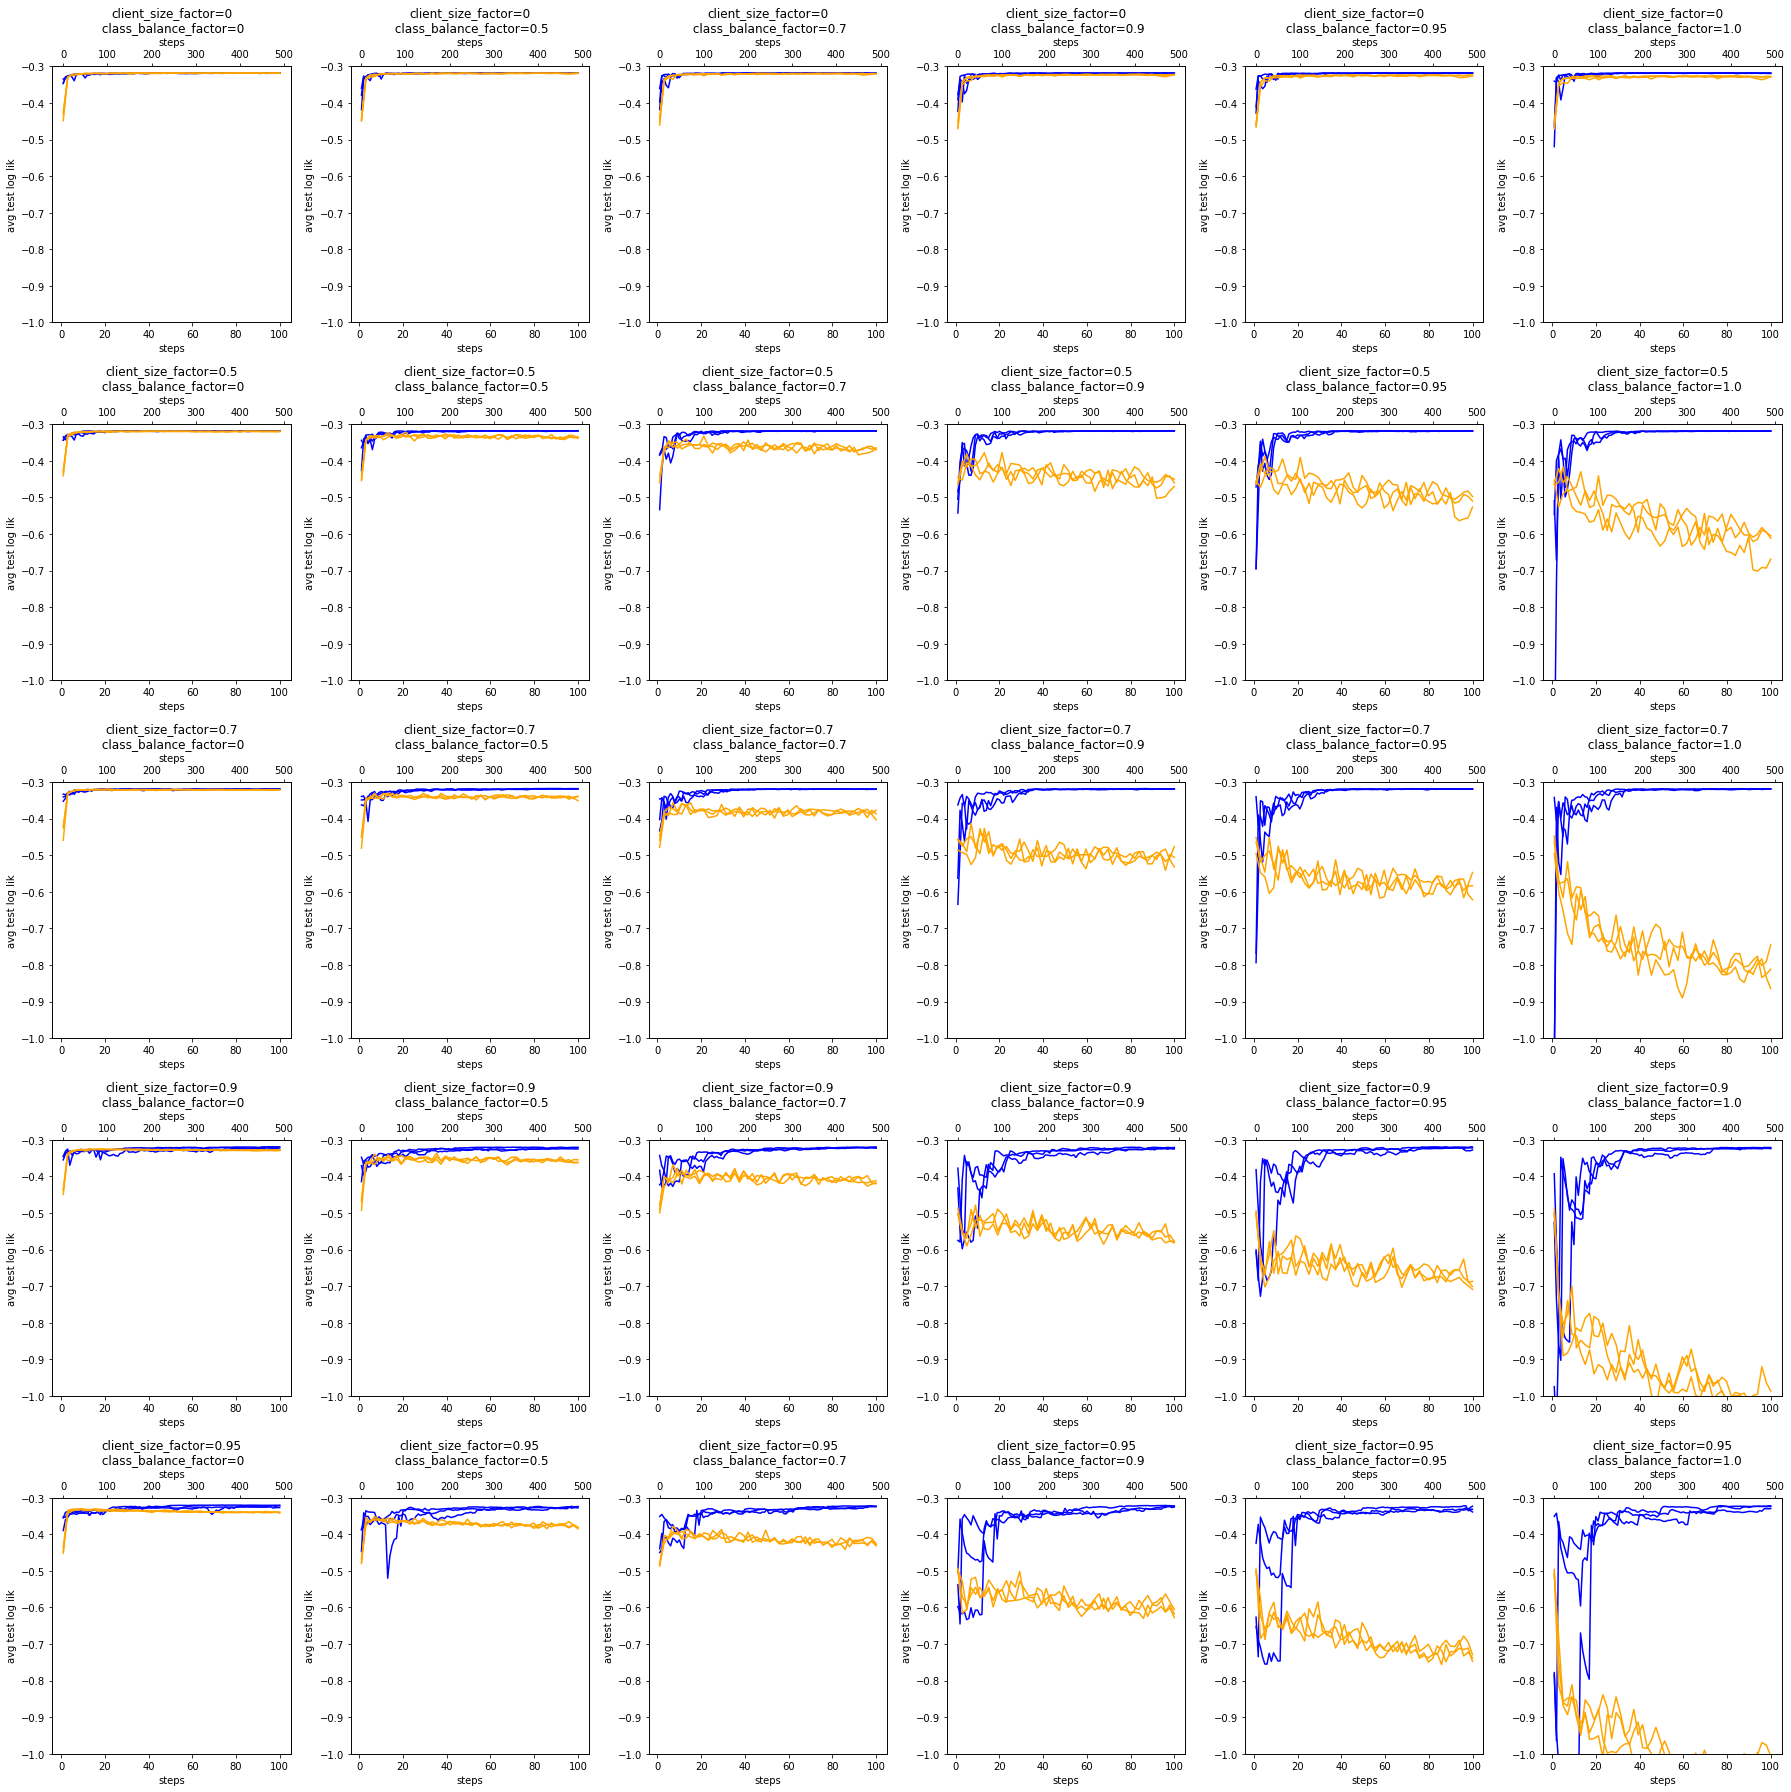

In [6]:
client_size_factors = sorted(experiment_config['dataset_dist.client_size_factor'])
class_balance_factors = sorted(experiment_config['dataset_dist.class_balance_factor'])

plt.figure(figsize=(25,25))
rows = len(client_size_factors)
cols = len(class_balance_factors)

for pvi_config, pvi_grid_experiment, pvi_grid_metric, bvi_config, bvi_grid_experiment, bvi_grid_metric in zip(pvi_configs, pvi_grid_experiments, pvi_grid_metrics, bvi_configs, bvi_grid_experiments, bvi_grid_metrics):
    client_size_factor = pvi_config['dataset_dist.client_size_factor']
    class_balance_factor = pvi_config['dataset_dist.class_balance_factor']
    
    client_size_factor_index = client_size_factors.index(client_size_factor)
    class_balance_factor_index = class_balance_factors.index(class_balance_factor)
    
    axes = plt.subplot(rows, cols, client_size_factor_index * cols + class_balance_factor_index + 1)
#     print(rho_index, inhom_index ,rho_index * cols + inhom_index + 1)
    
    if not len(pvi_grid_metric) == 0:
        pvi_values = []
        for metric in pvi_grid_metric:
            pvi_values.append(metric[1]['values'])
        pvi_values = np.array(pvi_values).T
        steps = np.atleast_2d(np.array(pvi_grid_metric[0][1]['steps'])).T
        
        axes.plot(steps, pvi_values, color='blue')
    
    axes2 = axes.twiny()
    
    if not len(bvi_grid_metric) == 0:
        bvi_values = []
        for metric in bvi_grid_metric:
            bvi_values.append(metric[1]['values'])
        bvi_values = np.array(bvi_values).T
        steps = np.atleast_2d(np.array(bvi_grid_metric[0][1]['steps'])).T
        
        axes2.plot(steps, bvi_values, color='orange')
        
    plt.title(f'client_size_factor={client_size_factor}\n class_balance_factor={class_balance_factor}')
    
#     axes.set_ylim([0.78, 0.86])
#     axes.set_xlim([0, 100])
    
    axes.set_xlabel('steps')
    axes2.set_xlabel('steps')
    axes.set_ylabel('avg test log lik')
    axes.set_ylim([-1.0, -0.3])
    
plt.tight_layout()